## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality.

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torch.utils.data import random_split

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
# from subword_nmt.learn_bpe import learn_bpe
# from subword_nmt.apply_bpe import BPE
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.normalizers import BertNormalizer
from tokenizers.pre_tokenizers import BertPreTokenizer
from tokenizers.processors import TemplateProcessing
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [4]:
with open("data.txt") as f:
    data = [l.rstrip().split("\t") for l in f]

print(f"Dataset size {len(data):,}")
print("Sample:")
data[:5]

Dataset size 50,000
Sample:


[['Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.',
  'Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.'],
 ['At Tupirmarka Lodge you will find a 24-hour front desk, room service, and a snack bar.',
  'В числе удобств лоджа Tupirmarka круглосуточная стойка регистрации и снэк-бар. Гости могут воспользоваться услугой доставки еды и напитков в номер.'],
 ['Featuring free WiFi in all areas, Naigao Xiaowo offers accommodation in Shanghai.',
  'Апартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.'],
 ['Each has a TV and a private bathroom with shower.',
  'В вашем распоряжении также телевизор и собственная ванная комната с душем.'],
 ['Your room comes with air conditioning and satellite TV.',
  'Номер оснащен кондиционером и спутниковым телевидением.']]

In [5]:
data_size = len(data)
train_size = int(0.8 * data_size)
test_size = int(0.15 * data_size)
val_size = data_size - train_size - test_size
train_data, test_data, val_data = random_split(
    data, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42)
)
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"Val size: {len(val_data)}")

Train size: 40000
Test size: 7500
Val size: 2500


In [6]:
en_text, ru_text = [], []
for en, ru in train_data:
    en_text.append(en)
    ru_text.append(ru)
len(en_text), len(ru_text)

(40000, 40000)

In [7]:
# Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set.
# The checkpoints are:

# * __21__ - minimal score to submit the homework, 30% of points

# * __25__ - good score, 70% of points

# * __27__ - excellent score, 100% of points

### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface:
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [8]:
tokenizer_en = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer_ru = Tokenizer(BPE(unk_token="[UNK]"))

trainer = BpeTrainer(special_tokens=["[UNK]", "[SOS]", "[EOS]", "[PAD]"])

tokenizer_en.normalizer = BertNormalizer()
tokenizer_ru.normalizer = BertNormalizer()
tokenizer_en.pre_tokenizer = BertPreTokenizer()
tokenizer_ru.pre_tokenizer = BertPreTokenizer()

tokenizer_en.train_from_iterator(en_text, trainer)
tokenizer_ru.train_from_iterator(ru_text, trainer)

tokenizer_en.post_processor = TemplateProcessing(
    single="[SOS] $A [EOS]",
    special_tokens=[
        ("[SOS]", tokenizer_en.token_to_id("[SOS]")),
        ("[EOS]", tokenizer_en.token_to_id("[EOS]")),
    ],
)
tokenizer_ru.post_processor = TemplateProcessing(
    single="[SOS] $A [EOS]",
    special_tokens=[
        ("[SOS]", tokenizer_ru.token_to_id("[SOS]")),
        ("[EOS]", tokenizer_ru.token_to_id("[EOS]")),
    ],
)

In [9]:
out_en = tokenizer_en.encode(en_text[1])
out_ru = tokenizer_ru.encode(ru_text[1])
print(out_en.ids)
print(out_en.tokens)
print(out_ru.ids)
print(out_ru.tokens)
print(f'English vocab size: {tokenizer_en.get_vocab_size()}')
print(f'Russian vocab size: {tokenizer_ru.get_vocab_size()}')

[1, 233, 169, 321, 107, 112, 15, 281, 257, 16, 2]
['[SOS]', 'guests', 'can', 'enjoy', 'the', 'on', '-', 'site', 'bar', '.', '[EOS]']
[1, 69, 1198, 216, 2027, 397, 15, 2]
['[SOS]', 'в', 'здании', 'отеля', 'открыт', 'бар', '.', '[EOS]']
English vocab size: 30000
Russian vocab size: 30000


In [10]:
tokenizer_en.token_to_id("[PAD]"), tokenizer_ru.token_to_id("[PAD]"),

(3, 3)

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
device

device(type='cuda')

In [13]:
def collate_batch(batch):
    src_list, trg_list = [], []
    for src, trg in batch:
        src_encoded = tokenizer_en.encode(src)
        src_list.append(torch.tensor(src_encoded.ids))

        trg_encoded = tokenizer_ru.encode(trg)
        trg_list.append(torch.tensor(trg_encoded.ids))

    src_padded = pad_sequence(src_list, padding_value=tokenizer_en.token_to_id("[PAD]"))
    trg_padded = pad_sequence(trg_list, padding_value=tokenizer_ru.token_to_id("[PAD]"))

    return src_padded, trg_padded

batch_size = 128
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_data, batch_size, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True, collate_fn=collate_batch)

src_batch, trg_batch = next(iter(train_dataloader))
src_batch.size(), trg_batch.size()

(torch.Size([45, 128]), torch.Size([54, 128]))

In [14]:
print(f'PAD idx EN: {tokenizer_en.token_to_id("[PAD]")}')
print(f'PAD idx RU: {tokenizer_ru.token_to_id("[PAD]")}')
print(f'SOS idx RU: {tokenizer_ru.token_to_id("[SOS]")}')

PAD idx EN: 3
PAD idx RU: 3
SOS idx RU: 1


In [15]:
class Encoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        _, hidden = self.rnn(embedded)
        return hidden


class Decoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, n_tokens)

    def forward(self, input, hidden):
        input = input.unsqueeze(dim=0)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        output, hidden = self.rnn(embedded, hidden)
        pred = self.out(output.squeeze(dim=0))
        return pred, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.hid_dim == decoder.hid_dim, "encoder and decoder must have same hidden dim"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "encoder and decoder must have equal number of layers"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len, batch_size = trg.shape
        preds = []
        hidden = self.encoder(src)

        # First input to the decoder is the <sos> token.
        input = trg[0, :]
        for i in range(1, trg_len):
            pred, hidden = self.decoder(input, hidden)
            preds.append(pred)
            teacher_force = random.random() < teacher_forcing_ratio
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

In [16]:
INPUT_DIM = tokenizer_en.get_vocab_size()
OUTPUT_DIM = tokenizer_ru.get_vocab_size()
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(device)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec).to(device)

In [17]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(30000, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(30000, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=30000, bias=True)
  )
)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 38,106,416 trainable parameters


In [19]:
PAD_IDX = tokenizer_ru.token_to_id("[PAD]")
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [20]:
def train(model, train_dataloader, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    i = 0
    for src, trg in tqdm(train_dataloader):

        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        i+=1
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(train_dataloader)

In [21]:
def evaluate(model, val_dataloader, criterion):

    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():

        for src, trg in tqdm(val_dataloader):

            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(val_dataloader)

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

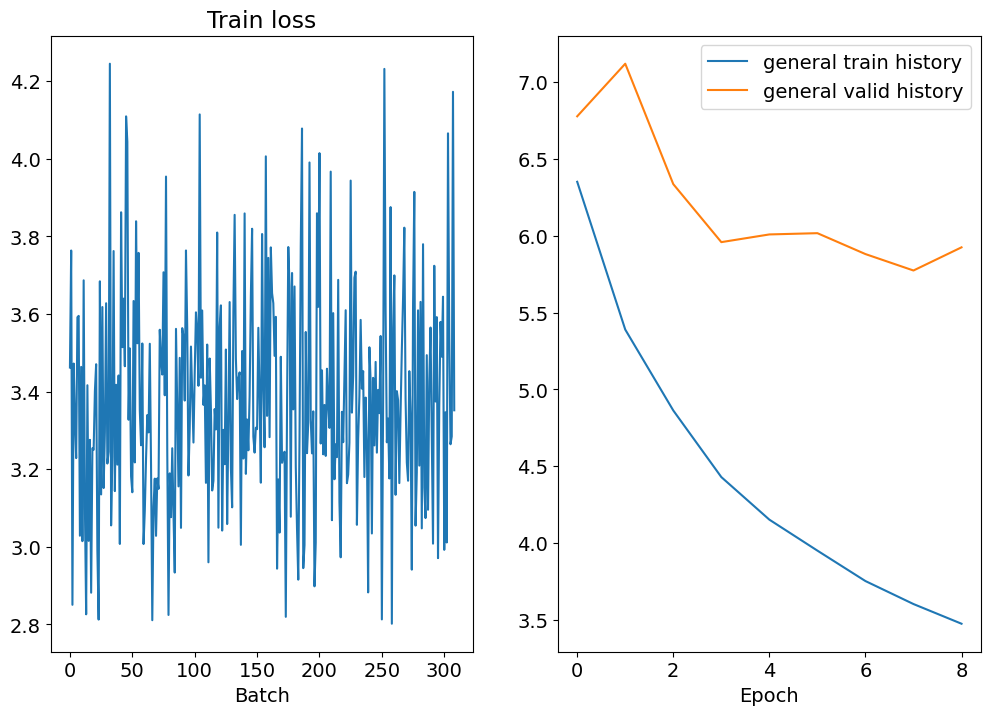

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 10 | Time: 2m 30s
	Train Loss: 3.380 | Train PPL:  29.377
	 Val. Loss: 5.859 |  Val. PPL: 350.369


In [24]:
for epoch in tqdm(range(N_EPOCHS)):

    start_time = time.time()

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, val_dataloader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [30]:
def get_text(x, TRG_tokenizer):
    text = TRG_tokenizer.decode(x)
    return text

def generate_translation(src, trg, model, TRG_tokenizer, n_ex=7):
    model.eval()
    src, trg = src.to(device), trg.to(device)

    output = model(src, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    for i in range(n_ex):
        original = get_text(list(trg[:,i].cpu().numpy()), TRG_tokenizer)
        generated = get_text(list(output[:, i]), TRG_tokenizer)

        print('Original: {}'.format(original))
        print('Generated: {}'.format(generated))
        print()


In [31]:
src, trg = next(iter(test_dataloader))
generate_translation(src, trg, model, tokenizer_ru)


Original: в каждом номере мотеля 6 ch ino - los angel es area имеется кондиционер и ванная комната .
Generated: все номера отеля типа « постель и завтрак » оснащены оснащены собственнои ваннои комнатои с душем и феном . . . . .

Original: апартаменты oz tur k находятся в городе сан джа к , в 10 км от города трабзон и в 24 км от города ма чка .
Generated: апартаменты « на расположены в городе , , в 1 км от города и в в км от от города . .

Original: гостям предоставляются тапочки и бесплатные туалетно - косметические принадлежности .
Generated: гостям предоставляются бесплатные туалетно - косметические принадлежности и фен . . . .

Original: также гости могут заказать гладильные услуги .
Generated: по запросу предоставляются гладильные принадлежности . .

Original: в распоряжении гостеи дома для отпуска « станция солнечная » принадлежности для барбекю .
Generated: гости апартаментов для отпуска casa могут могут могут воспользоваться принадлежностями для барбекю . .

Original: апартамент

In [32]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [33]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for src, trg in tqdm(test_dataloader):

        src, trg = src.to(device), trg.to(device)

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, tokenizer_ru) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, tokenizer_ru) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

  0%|          | 0/59 [00:00<?, ?it/s]

In [34]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

41.36547577900468